In [96]:
%matplotlib inline

import louvain
import igraph as ig
from igraph.drawing import plot
from igraph.clustering import VertexClustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

In [216]:
# G = ig.Graph.Read_Ncol("reactome_edgelist.txt", directed=False)
G = ig.Graph.Read_GML("embedded_karate.gml")
G = G.clusters(mode="weak").giant()

In [217]:
# construct compolete graphs based on similarity
S1 = np.array(list(G.get_adjacency()))
S2 = cosine_similarity(S1)

S = S1 * (S1 + 5 * S2)

In [163]:
S

array([[ 0.        ,  1.41666667,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.41666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [164]:
H = ig.Graph.Adjacency(np.ones((len(G.vs), len(G.vs))).tolist())
H.es["weight"] = S[S.nonzero()]

In [89]:
G.es["weight"] = S[S.nonzero()]

In [131]:
resolutions = np.arange(0.25, 4.25, 0.25)

In [132]:
num_repeats = 100
parts = [[louvain.find_partition(G, method="RBConfiguration", 
                                 weight=G.es["weight"], resolution_parameter=r) for i in range(num_repeats)] 
         for r in resolutions]

KeyError: 'Attribute does not exist'

In [92]:
modularities = np.array([[parts[i][j].quality for j in range(num_repeats)] for i in range(len(resolutions))])

In [93]:
NMIs = np.array([[normalized_mutual_info_score(parts[i][j].membership, G.vs["club"])
                  for j in range(num_repeats)] for i in range(len(resolutions))])

In [94]:
NMIs.max()

0.83717011721869428

In [77]:
i, j = np.unravel_index(NMIs.argmax(), NMIs.shape)

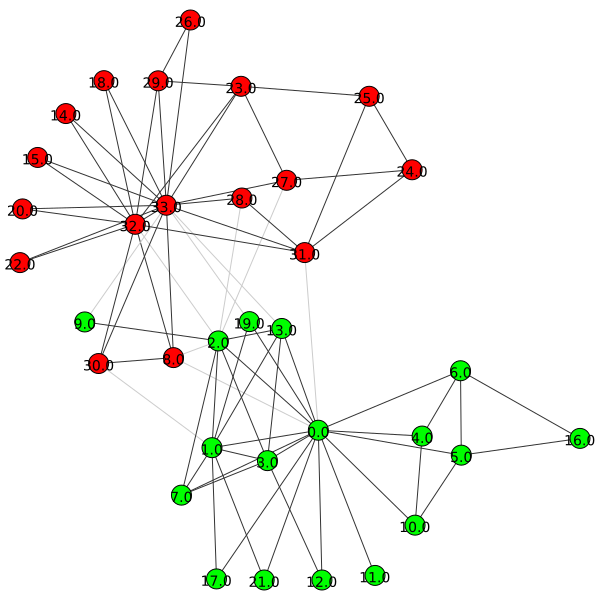

In [78]:
plot(parts[i][j])
# plot(parts[8][0])

In [30]:
conversion = {"l":0, "c":1, "n":2}
membership = [conversion[k] for k in G.vs["value"]]

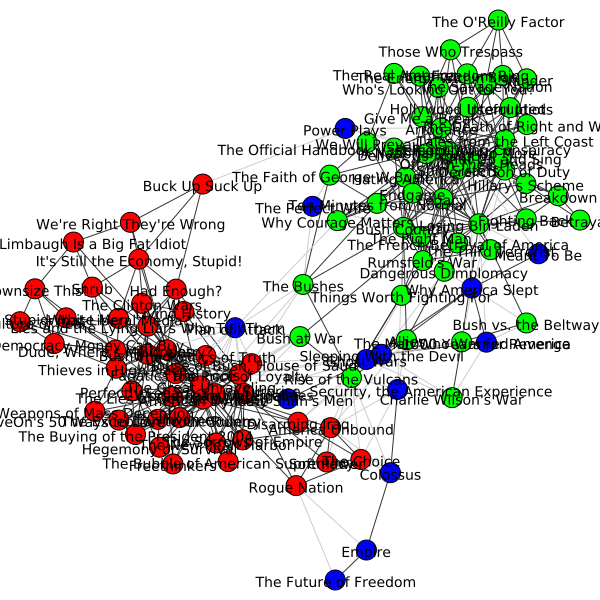

In [33]:
plot(VertexClustering(graph=G, membership=membership))

In [112]:
membership, quality = louvain.find_partition_multiplex(layers=[
    louvain.Layer(graph=G, method="RBConfiguration", layer_weight=0.1, resolution_parameter=r) for r in resolutions
])

In [10]:
res_parts = louvain.bisect(G, method='RBConfiguration', resolution_range=[0,10])

In [16]:
plot(res_parts.values()[0])

TypeError: not all arguments converted during string formatting

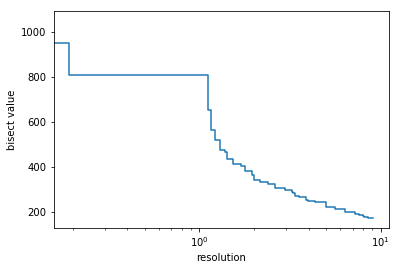

In [11]:
res_df = pd.DataFrame({
         'resolution': res_parts.keys(),
         'bisect_value': [bisect.bisect_value for bisect in res_parts.values()]});
plt.step(res_df['resolution'], res_df['bisect_value']);
plt.xscale('log');
plt.xlabel("resolution")
plt.ylabel("bisect value")

In [293]:
resolutions = np.arange(0.1, 1.01, 0.01)
# resolutions = np.array([0.6, 1.0])

In [308]:
#%%
# number of nodes in G
n = len(G.vs)

# number of slices
D = len(resolutions)

# initialise slices
slices = [G for sl in range(D)]

# initialise ids
for H in slices:
    H.vs['id'] = np.arange(n)

# initialise edge data frame for each slice
E = [pd.DataFrame(H.get_edgelist(), columns=['source', 'target']) for H in slices]
 
# Set time for edges
for t in range(D):
    E[t]['t'] = t + 1

# Concatenate
E = pd.concat(E)

# Make sure that the id's are different for different slices
E['source'] = ['{0}-{1}'.format(row['source'], row['t']) for idx, row in E.iterrows()]
E['target'] = ['{0}-{1}'.format(row['target'], row['t']) for idx, row in E.iterrows()]
 
# Add weight
E['weight'] = 1.0;
 
#%%
# Add interslice links (to adjacent layers)
w = 0.1
for i in range(D - 1):
    for v in slices[i].vs:
        for u in slices[i + 1].vs:
            if v['id'] == u['id']:
                source = '{0}-{1}'.format( v.index, i + 1)
                target = '{0}-{1}'.format(u.index, i + 2)
                E = E.append([{'source': source, 'target': target, 'weight': w, 't': 'interslice'}])
                
def GraphFromPandasEdgeList(edges_df, edge_cols = ['source', 'target'], **kwargs):
 
    def renumber_edges(edges, ids):
        for e in edges:
            if not e[0] in ids:
                raise Exception('Couldn\'t find {0} in nodes dataframe'.format(e[0]))
            e0 = ids[e[0]]
            e1 = ids[e[1]]
            yield (e0, e1)
 
    # Renumber nodes
    node_id = ig.UniqueIdGenerator()
    nodes = edges_df[edge_cols].stack().unique()
    for node in nodes:
        node_id.add(node)
 
    # Create graph
    G = ig.Graph(**kwargs)
    G.add_vertices(len(nodes))
    G.vs['id'] = node_id.values()

    # Renumber edges so that they are consistent
    # with the node numbering.
    edges = renumber_edges(
               edges_df[edge_cols].itertuples(index=False), 
               node_id)
    G.add_edges(edges)

    for k, v in edges_df.iteritems():
        if not k in edge_cols:
            G.es[k] = list(v)

    return G

# create multi slice graph
H = GraphFromPandasEdgeList(E, directed=False)

# subgraphs for each layer
subgraphs = [H.subgraph_edges(H.es.select(t_eq = i + 1), delete_vertices=False) for i in range(D)]

# interslice subgraph
H_interslice = H.subgraph_edges(H.es.select(t_eq = 'interslice'), delete_vertices=False)

# multiplex louvain
membership, quality = louvain.find_partition_multiplex(
    layers = [louvain.Layer(subgraphs[i], "RBConfiguration", resolution_parameter=resolutions[i]) for i in range(D)]
    + [louvain.Layer(H_interslice, 'CPM', resolution_parameter=0)]
   )

In [309]:
nodes = np.array([n["id"] for n in H.vs])

In [310]:
nodes.reshape(D, -1)

array([['0-1', '1-1', '2-1', ..., '29-1', '24-1', '26-1'],
       ['0-2', '1-2', '2-2', ..., '29-2', '24-2', '26-2'],
       ['0-3', '1-3', '2-3', ..., '29-3', '24-3', '26-3'],
       ..., 
       ['0-89', '1-89', '2-89', ..., '29-89', '24-89', '26-89'],
       ['0-90', '1-90', '2-90', ..., '29-90', '24-90', '26-90'],
       ['0-91', '1-91', '2-91', ..., '29-91', '24-91', '26-91']], 
      dtype='|S5')

In [311]:
membership_array = np.array(membership).reshape(D, -1)

In [312]:
membership_array

array([[  9, 272, 214, ..., 430,  59, 119],
       [213,  74,   9, ..., 119, 431, 119],
       [169,  74, 434, ...,   9,  59, 442],
       ..., 
       [269, 772, 116, ..., 419, 777, 419],
       [ 45, 773,  92, ..., 118,  92, 118],
       [ 45, 209, 209, ..., 210, 270, 118]])

In [316]:
[len(np.unique(i)) for i in membership_array]

[18,
 15,
 18,
 20,
 15,
 18,
 13,
 11,
 19,
 17,
 12,
 12,
 18,
 12,
 15,
 13,
 11,
 17,
 15,
 15,
 15,
 13,
 13,
 8,
 12,
 9,
 15,
 18,
 22,
 19,
 14,
 16,
 14,
 18,
 16,
 12,
 17,
 12,
 14,
 11,
 19,
 17,
 15,
 22,
 19,
 14,
 12,
 16,
 17,
 18,
 20,
 12,
 16,
 21,
 17,
 15,
 17,
 11,
 15,
 17,
 17,
 16,
 20,
 18,
 15,
 12,
 19,
 23,
 20,
 19,
 23,
 16,
 17,
 13,
 16,
 13,
 14,
 20,
 17,
 16,
 16,
 10,
 8,
 16,
 14,
 15,
 18,
 18,
 16,
 13,
 11]

In [313]:
sorted_columns = np.argsort(membership_array[0,:])

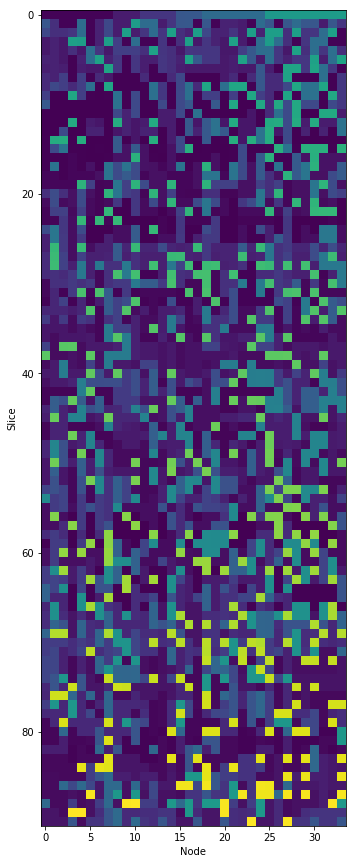

In [314]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(membership_array[:, sorted_columns])
plt.xlabel("Node")
plt.ylabel("Slice")